#### Imports

In [127]:
using Plots
using Random

# Motion Planning Using Convex Optimization

## Model

In [128]:
struct Point
    x::Float64
    y::Float64
end

In [129]:
struct Pose
    position::Point
    orientation::Float64
end

## Random Map Generation

### Random Convex Polygon Generation

In [130]:
function GenerateRandomConvexPolygon(numberOfVertices::Int64)
    # Still remains a test for convexity and 
    #keep up with the computation until a convex poligon is found
    
    #Generate two lists of random X and Y coordinates
    xCoordinateRandomPoints = []
    yCoordinateRandomPoints = []

    for i in 1:numberOfVertices
        append!(xCoordinateRandomPoints, rand())
        append!(yCoordinateRandomPoints, rand())
    end

    #Sort them
    sort!(xCoordinateRandomPoints)
    sort!(yCoordinateRandomPoints)

    #Isolate the extreme points
    minimumX = xCoordinateRandomPoints[1]
    maximumX = xCoordinateRandomPoints[numberOfVertices]
    minimumY = yCoordinateRandomPoints[1]
    maximumY = yCoordinateRandomPoints[numberOfVertices]

    #Randomly divide the interior points into two chains
    xVectors = []
    yVectors = []

    lastTop = minimumX
    lastBot = minimumX;
    
    #Extract the vector components
    for i in 2:numberOfVertices-1
        x = xCoordinateRandomPoints[i];

        if rand(Bool)
            append!(xVectors, x - lastTop)
            lastTop = x;
        else 
            append!(xVectors, x - lastBot)
            lastBot = x;
        end
    end


    append!(xVectors, maximumX - lastTop)
    append!(xVectors, lastBot - maximumX)

    lastLeft = minimumY
    lastRight = minimumY;

    for i in 2:numberOfVertices-1
        y = yCoordinateRandomPoints[i];

        if rand(Bool)
            append!(yVectors, y - lastLeft)
            lastLeft = y;
        else 
            append!(yVectors, lastRight - y)
            lastRight = y;
        end
    end

    append!(yVectors, maximumY - lastLeft)
    append!(yVectors, lastRight - maximumY)

    shuffle(yVectors);

    #Randomly pair up the X- and Y-components
    points = []
    angles = []

    for i in 1:numberOfVertices
        push!(points, Point(xVectors[i],yVectors[i]))
        append!(angles, atan(yVectors[i],xVectors[i]))
    end

    order = sortperm(angles)
    

    points = points[order]

    x = 0.0
    y = 0.0
    minPolygonX = 0;
    minPolygonY = 0;
    newPoints = []
    for i in 1:numberOfVertices 
        push!(newPoints, Point(x,y))

        x += points[i].x;
        y += points[i].y;

        minPolygonX = min(minPolygonX, x)
        minPolygonY = min(minPolygonY, y)
    end
    

    xShift = minimumX - minPolygonX;
    yShift = minimumY - minPolygonY;

    for i in 1:numberOfVertices 
        p = points[i]
        points[i] = Point(p.x + xShift, p.y + yShift)
    end
    
    return points;
end


GenerateRandomConvexPolygon (generic function with 1 method)

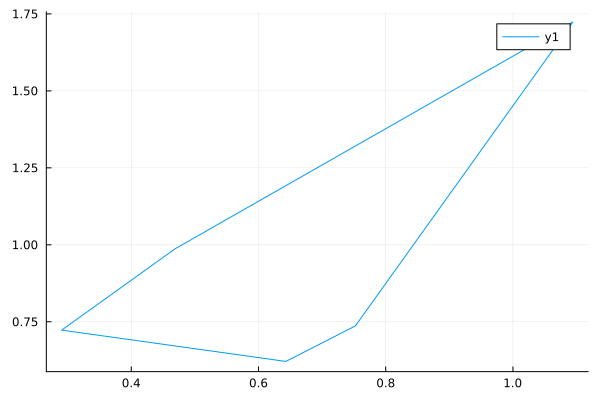

In [204]:
n_vertice = 5
a = GenerateRandomConvexPolygon(n_vertice)
xs = []
ys = []
for i in 1:n_vertice
    append!(xs,a[i].x)
    append!(ys,a[i].y)
end

append!(xs,a[1].x)
append!(ys,a[1].y)

plot(xs,ys)

In [205]:

isConvex(a)

true

reference: https://cglab.ca/~sander/misc/ConvexGeneration/convex.html

### Convex Test for Polygons

In [202]:
function isConvex(points)
    convex = true
    i = 1
    m_min = 0
    m_max = 0
    prev = 0
    next = 0
    points_aux = []
    k = 1
    while (i <= length(points)) && convex
        prev = (length(points)+i-2)%(length(points))+1
        next = (i)%(length(points))+1

        #println("\nPonto atual: ", i, ", Ponto anterior: ", prev, " Ponto seguinte: ", next)

        x_prev = points[prev].x
        x_now = points[i].x
        x_next = points[next].x
        y_prev = points[prev].y
        y_now = points[i].y
        y_next = points[next].y

        #println("\nPonto atual: x = ", x_now, ", y = ", y_now, "\n")

        for j in 1:length(points)
            if (j != prev) && (j != next) && (j != i)
                #println("O ponto = ", j, " será analisado!")
                push!(points_aux, points[j])
                k += 1
            end
        end
        
        #println("\n")

        ang1 = 180*atan((y_prev - y_now)/(x_prev - x_now))/pi
        ang2 = 180*atan((y_next - y_now)/(x_next - x_now))/pi
        
        if (x_prev < x_now)
            ang1 = 180 + ang1
        end
        if (x_next < x_now)
            ang2 = 180 + ang2
        end

        if ang1<ang2 
            ang_min = ang1
            ang_max = ang2
        else
            ang_max = ang1
            ang_min = ang2
        end

        if (signbit(ang_min) != 1 && signbit(ang_max) != 1 && abs(ang_min-ang_max) > 180)
            ang_max = ang_max-360
            ang_aux = ang_min
            ang_min = ang_max
            ang_max = ang_aux
        elseif (signbit(ang_min) && abs(ang_min-ang_max) > 180)
            ang_min = 360 + ang_min
            ang_aux = ang_max
            ang_max = ang_min
            ang_min = ang_aux
        end

            

        #println("Ang_min = ", ang_min)
        #println("Ang_max = ", ang_max)

        for p in points_aux
            #println("\nPonto ", i, ", em relação ao Ponto x = ", p.x, ", y = ", p.y)
            ang = 180*atan((p.y - y_now)/(p.x - x_now))/pi
            if (p.x < x_now)
                ang = 180 + ang
            end
            if (ang < ang_min) || (ang > ang_max)
                if signbit(ang)
                    ang = 360+ang
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        #println("Não é convexo, pois ang = ", ang)
                        break
                    end
                else
                    convex = false
                    #println("Não é convexo, pois ang = ", ang)
                    break
                end
            end
            #println("Sem problemas de convexidade, pois ang = ", ang)
        end

        points_aux = []

        i += 1
    end   
    return convex
end

isConvex (generic function with 1 method)